## Load packages

In [1]:

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
#import tyxe
import itertools
import math
from typing import Union, Optional, Dict, List

import os
import sys
from datetime import datetime
import torch
import torch.nn.functional as F
from tensorboardX import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

from pathlib import Path
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
os.chdir(parentdir)
sys.path.insert(0, str(Path(parentdir, 'src')) ) 

from utils.config import configuration
from data.generate_dataset import generate_dataset
from models.MLP import Net
from models.ensemble import Ensemble
from training.training_1d_regre import train

import torch
torch.cuda.is_available()

/home/TUG/steger-tug/miniconda3/envs/pip-torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
sns.set(style="darkgrid")
matplotlib.rcParams['figure.dpi']= 100
sns.set(style="white")

## Start training

In [3]:
args = ['--dataset', 'noisy_sinus', 
        '--method', 'f_s_SVGD', # f_s_SVGD SVGD
        '--epochs', '10001',
        '--n_particles', '20', 
        '--num_hidden', '2',
        '--size_hidden', '50'
        ]

config = configuration(args)
config.n_particles

Configuration
['--dataset', 'noisy_sinus', '--method', 'f_s_SVGD', '--epochs', '10001', '--n_particles', '20', '--num_hidden', '2', '--size_hidden', '50']


20

In [4]:
date =  datetime.now().strftime('%H-%M-%S')
exp_dir = 'exp_'+datetime.now().strftime('%m-%d-%H-%M')
torch.manual_seed(config.random_seed)

if config.noise: 
    alg = 'sto'
else: 
    alg = 'det'

f_date = datetime.now().strftime('%Y-%m-%d')

dout_dir = './out/'+ f_date + '/'+ config.dataset + '/' +config.method +'/'+ config.ann_sch+str(config.annealing_steps) +'/'+config.where_repulsive + 'part_'+str(config.n_particles)+'/lr_'+str(config.lr)+'/seed_'+str(config.random_seed)+'_run_' + date 

config.out_dir = dout_dir

In [5]:
writer = SummaryWriter(log_dir=os.path.join(config.out_dir, 'summary'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

writer.add_text('Comment', config.comment, 0)
configu = dict(config.__dict__)
del configu['comment']

writer.add_text('Hparams', str(configu), 0)

Generating sinus data...
[-9, 9] [-9, 9]


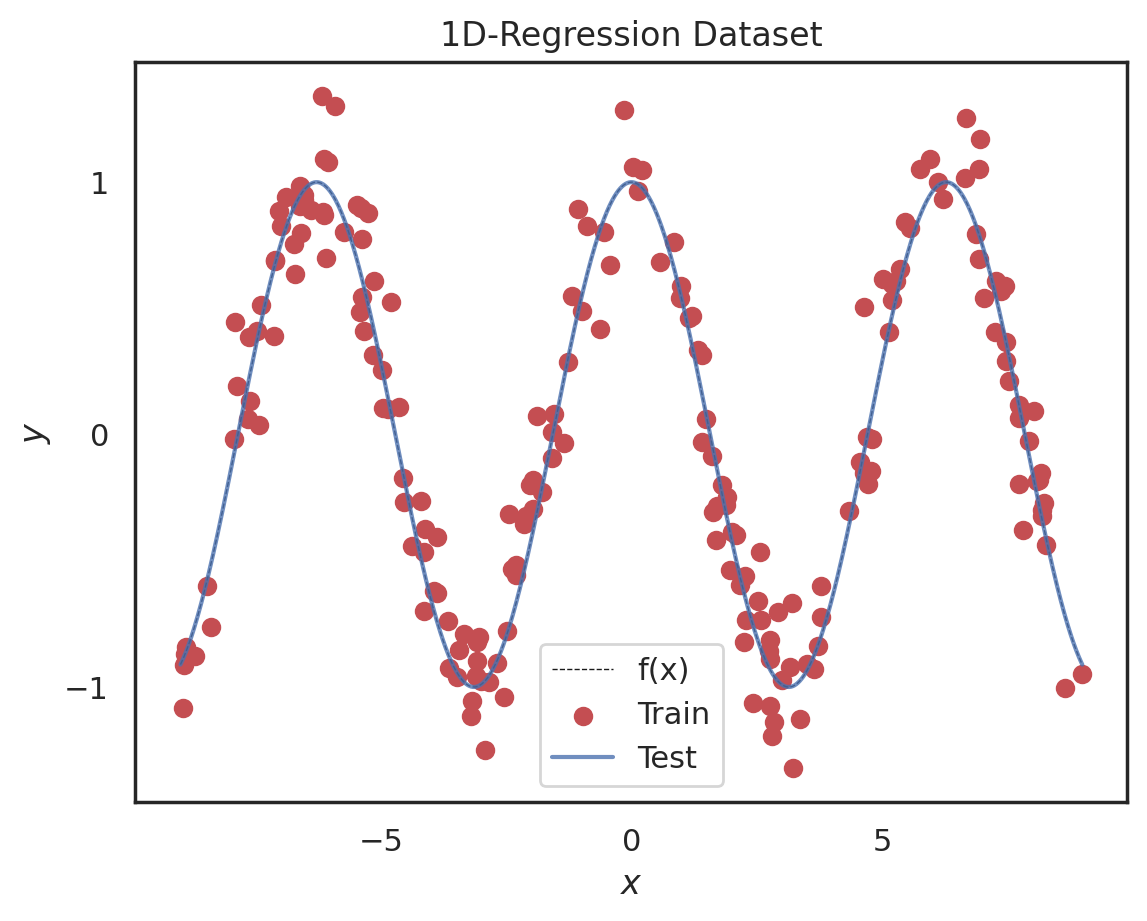

In [6]:
data, classification = generate_dataset(config)
data.plot_dataset()

In [7]:
layer_sizes = [data.in_shape[0], data.out_shape[0]]

for i in range(config.num_hidden):
    layer_sizes.insert(-1, config.size_hidden)

mnet = Net(layer_sizes, classification = classification, act=F.relu,out_act = None).to(device)


-------------------------Start training-------------------------


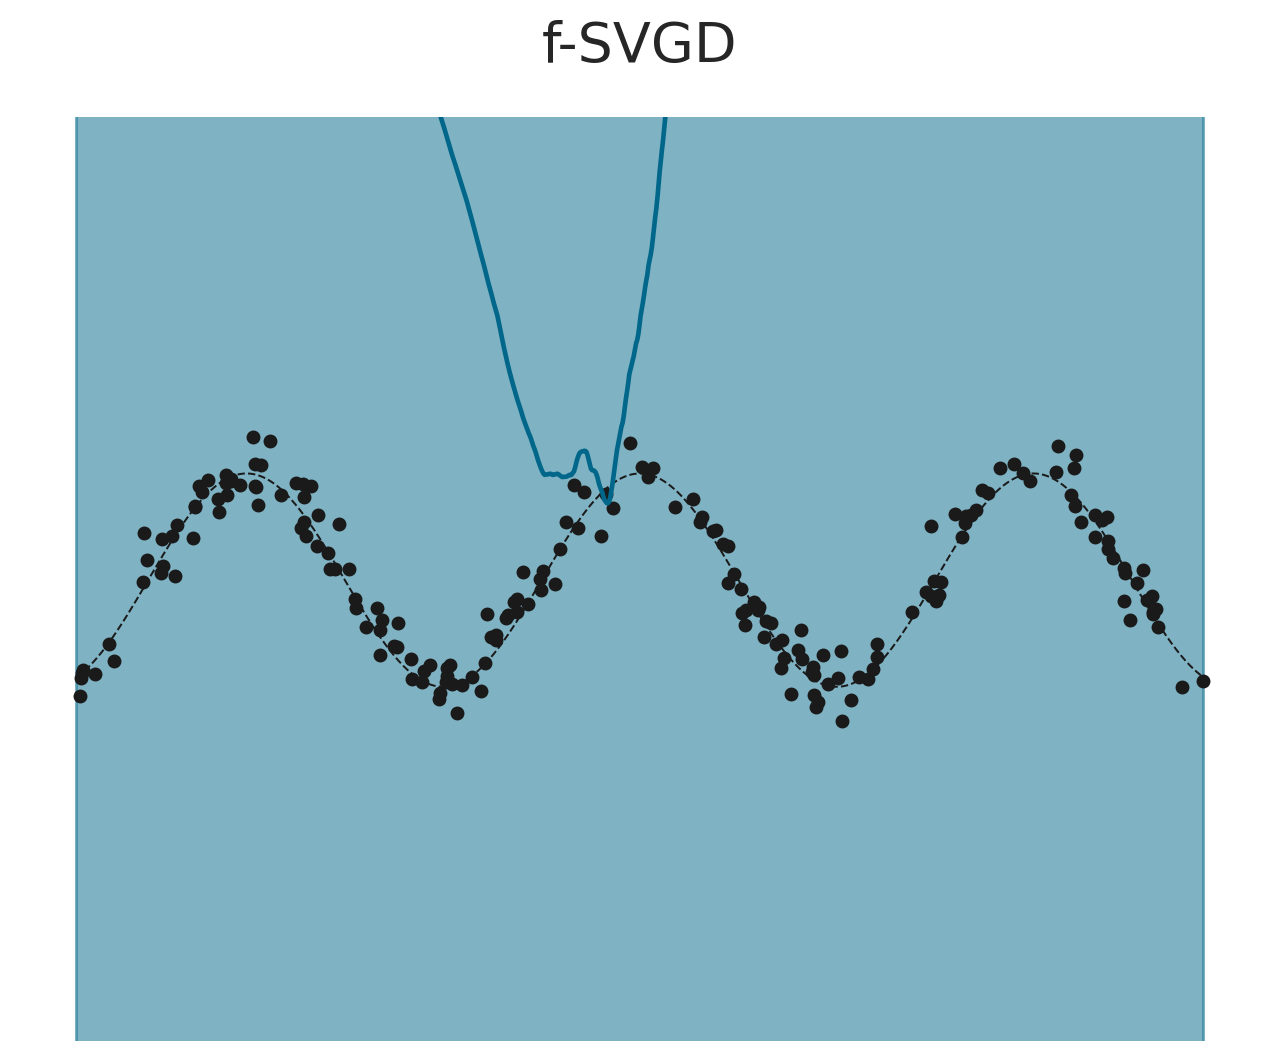

Train iter: 0  train mse: tensor(5165.2817, device='cuda:0') test mse tensor(6267.0679, device='cuda:0')


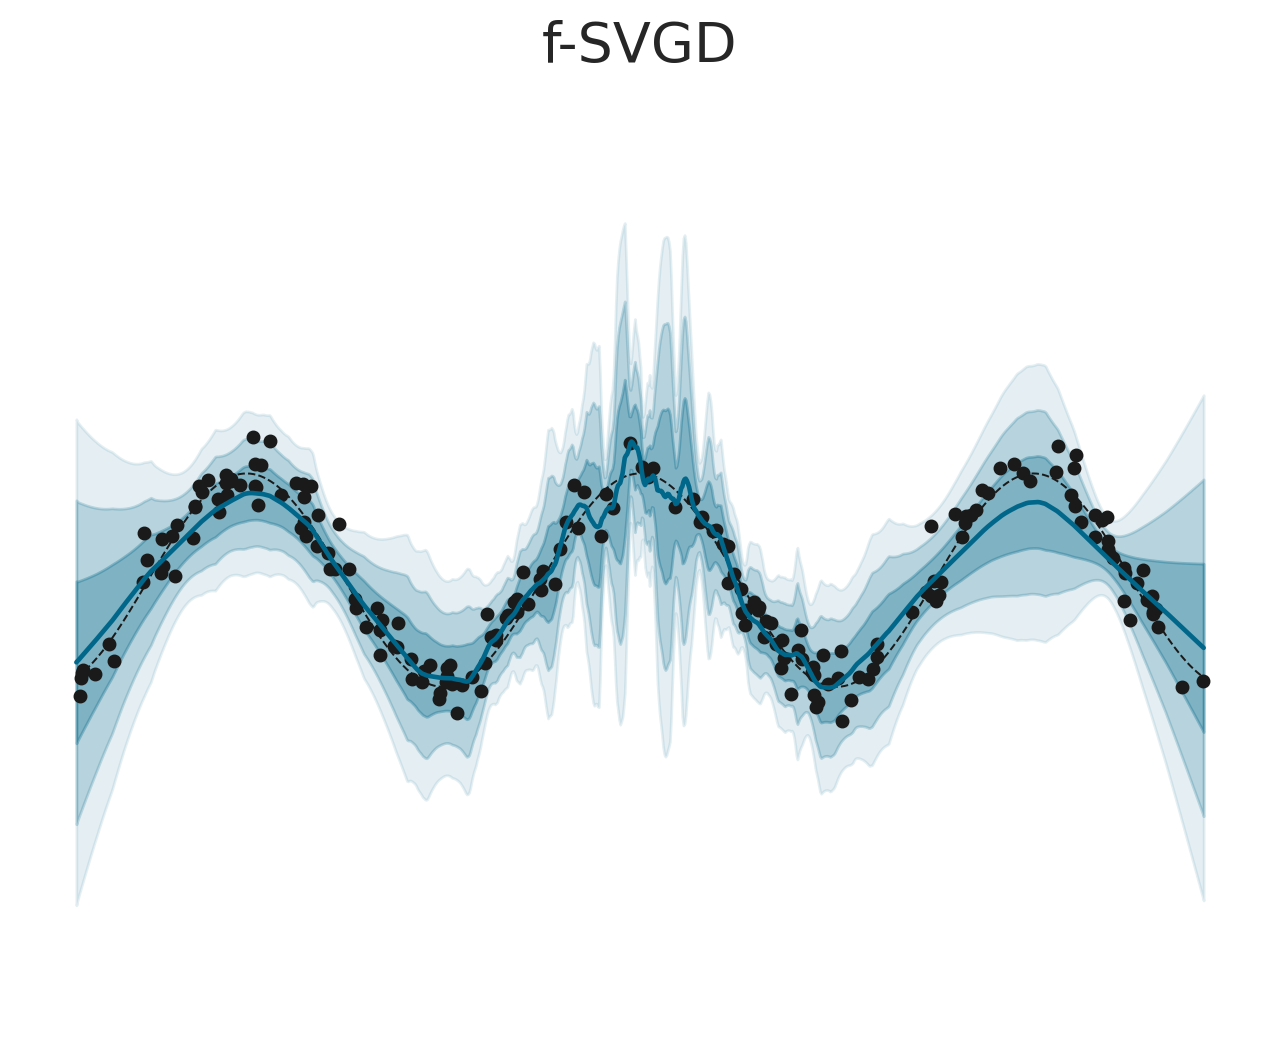

Train iter: 1000  train mse: tensor(0.0643, device='cuda:0') test mse tensor(0.0710, device='cuda:0')


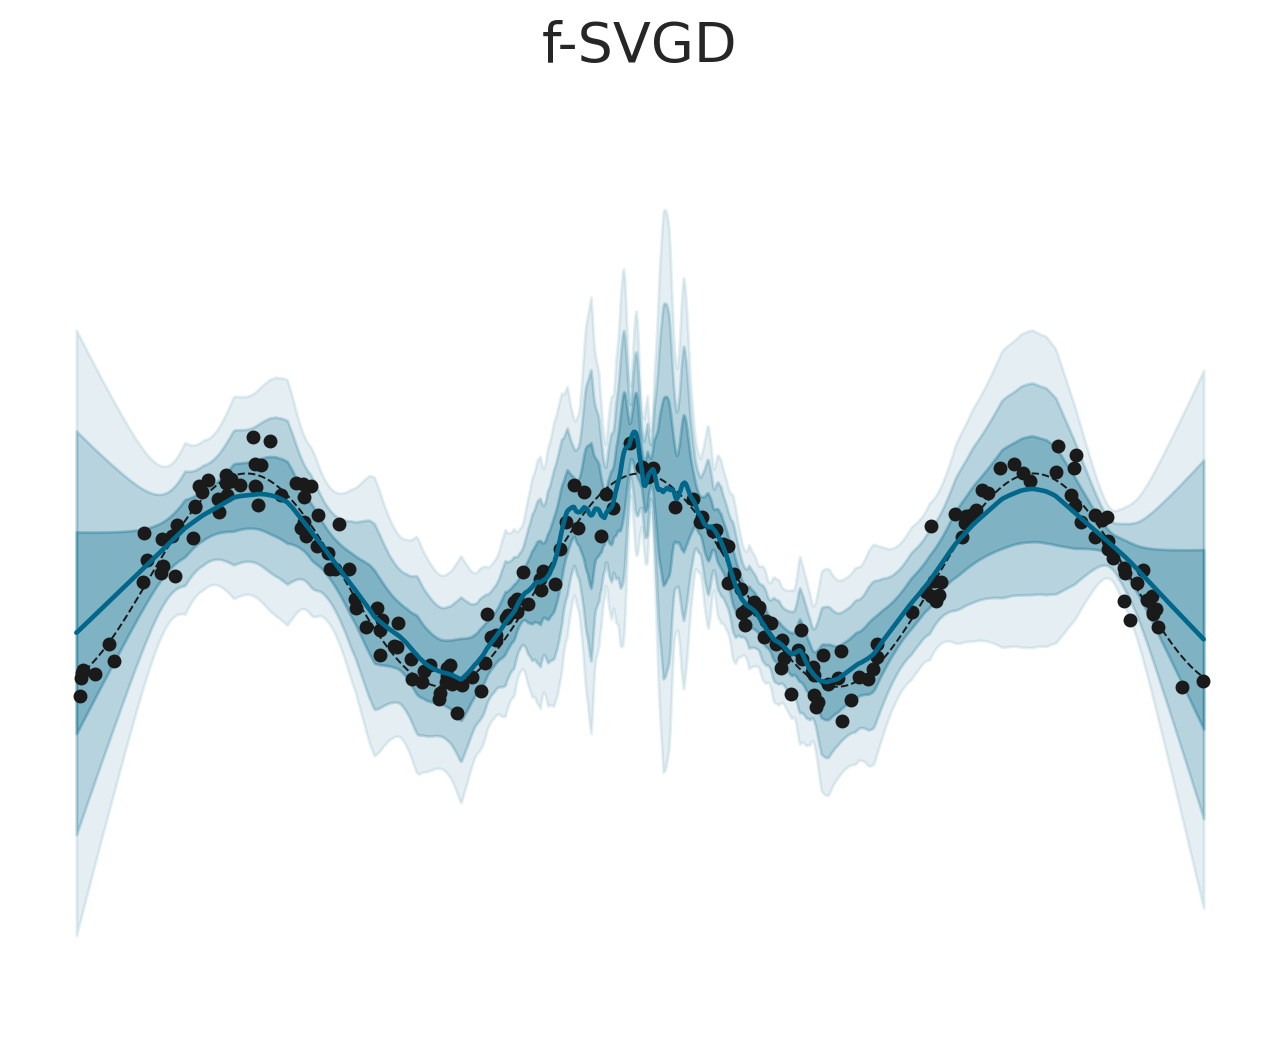

Train iter: 2000  train mse: tensor(0.0705, device='cuda:0') test mse tensor(0.0827, device='cuda:0')


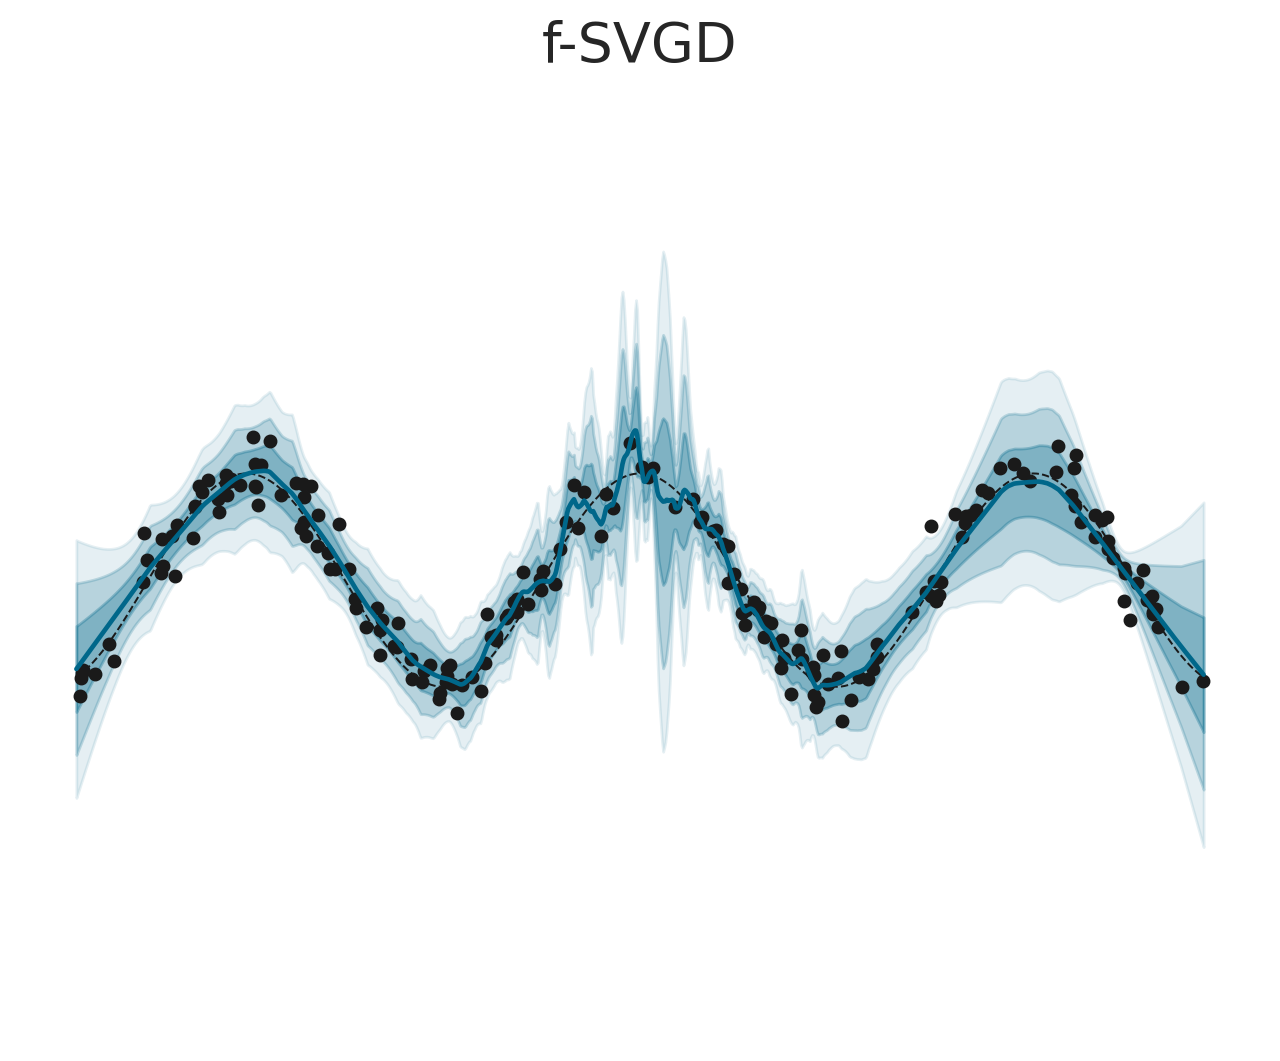

Train iter: 3000  train mse: tensor(0.0311, device='cuda:0') test mse tensor(0.0333, device='cuda:0')


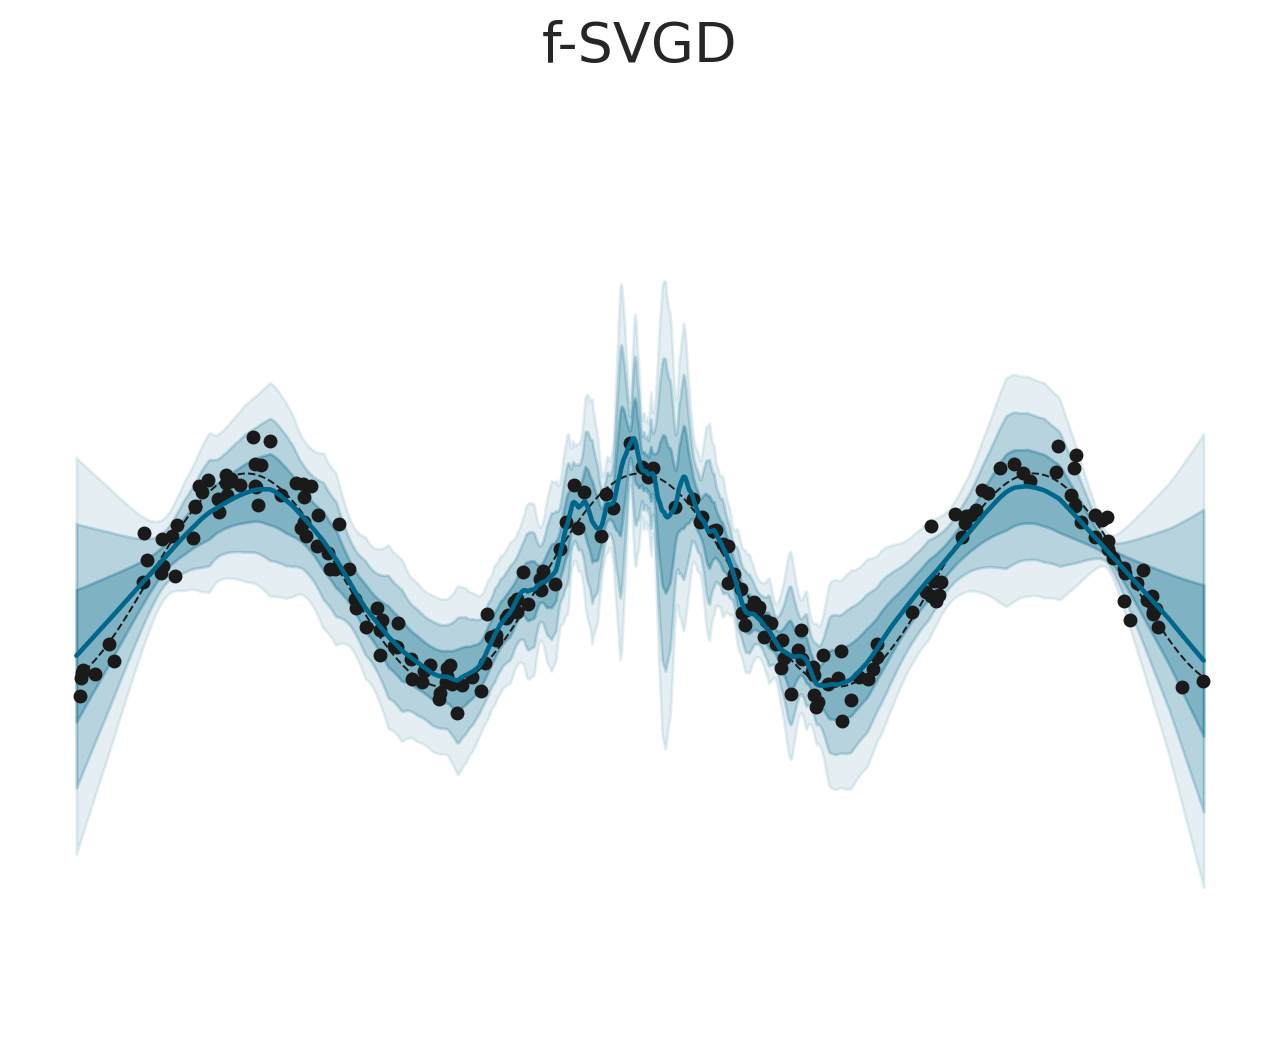

Train iter: 4000  train mse: tensor(0.0470, device='cuda:0') test mse tensor(0.0487, device='cuda:0')


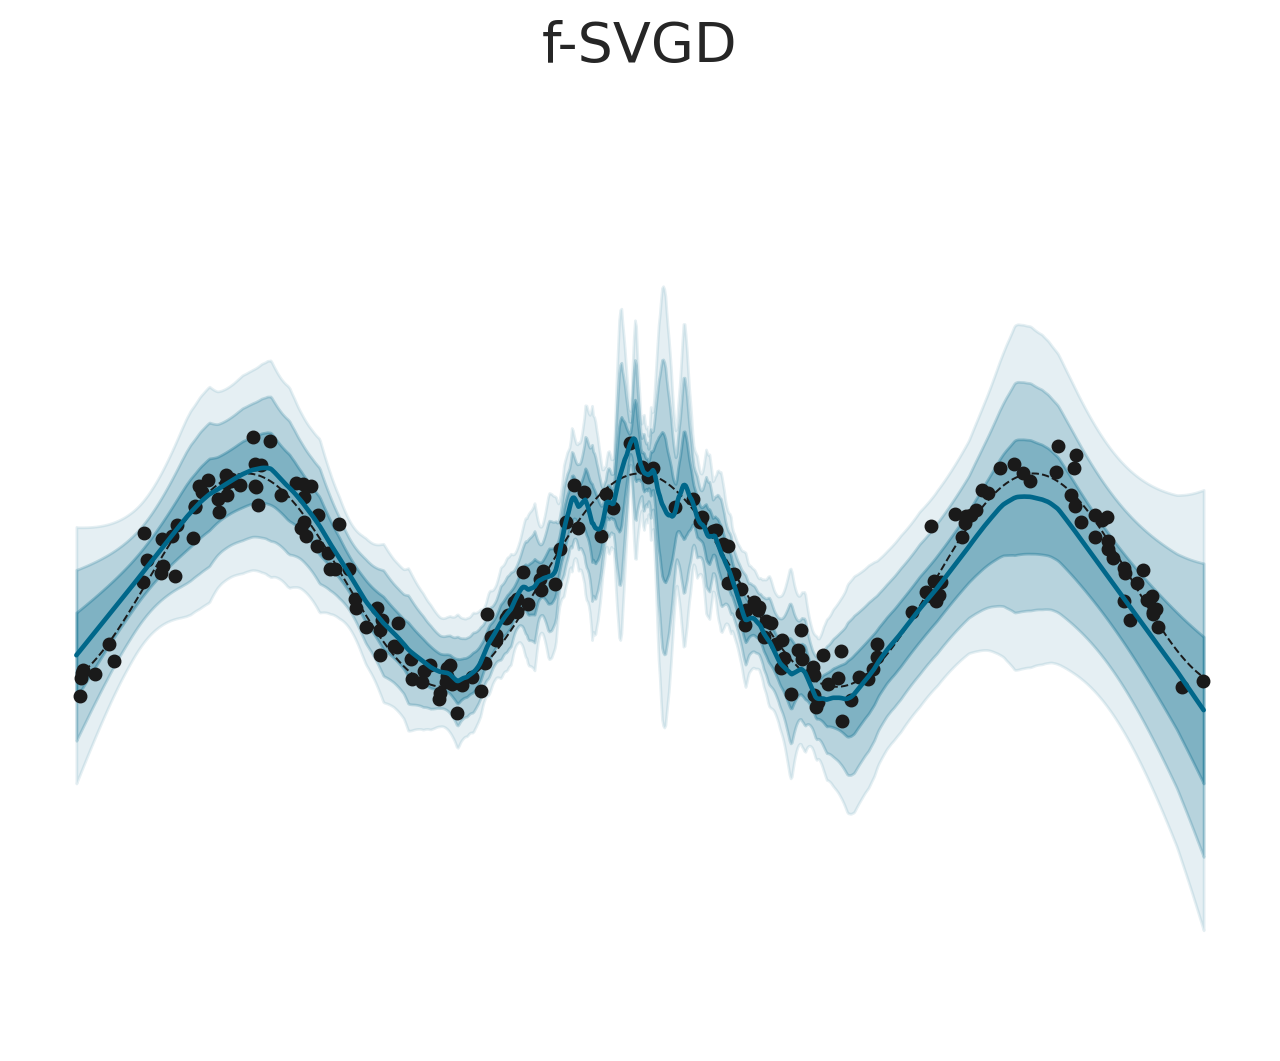

Train iter: 5000  train mse: tensor(0.0654, device='cuda:0') test mse tensor(0.0653, device='cuda:0')


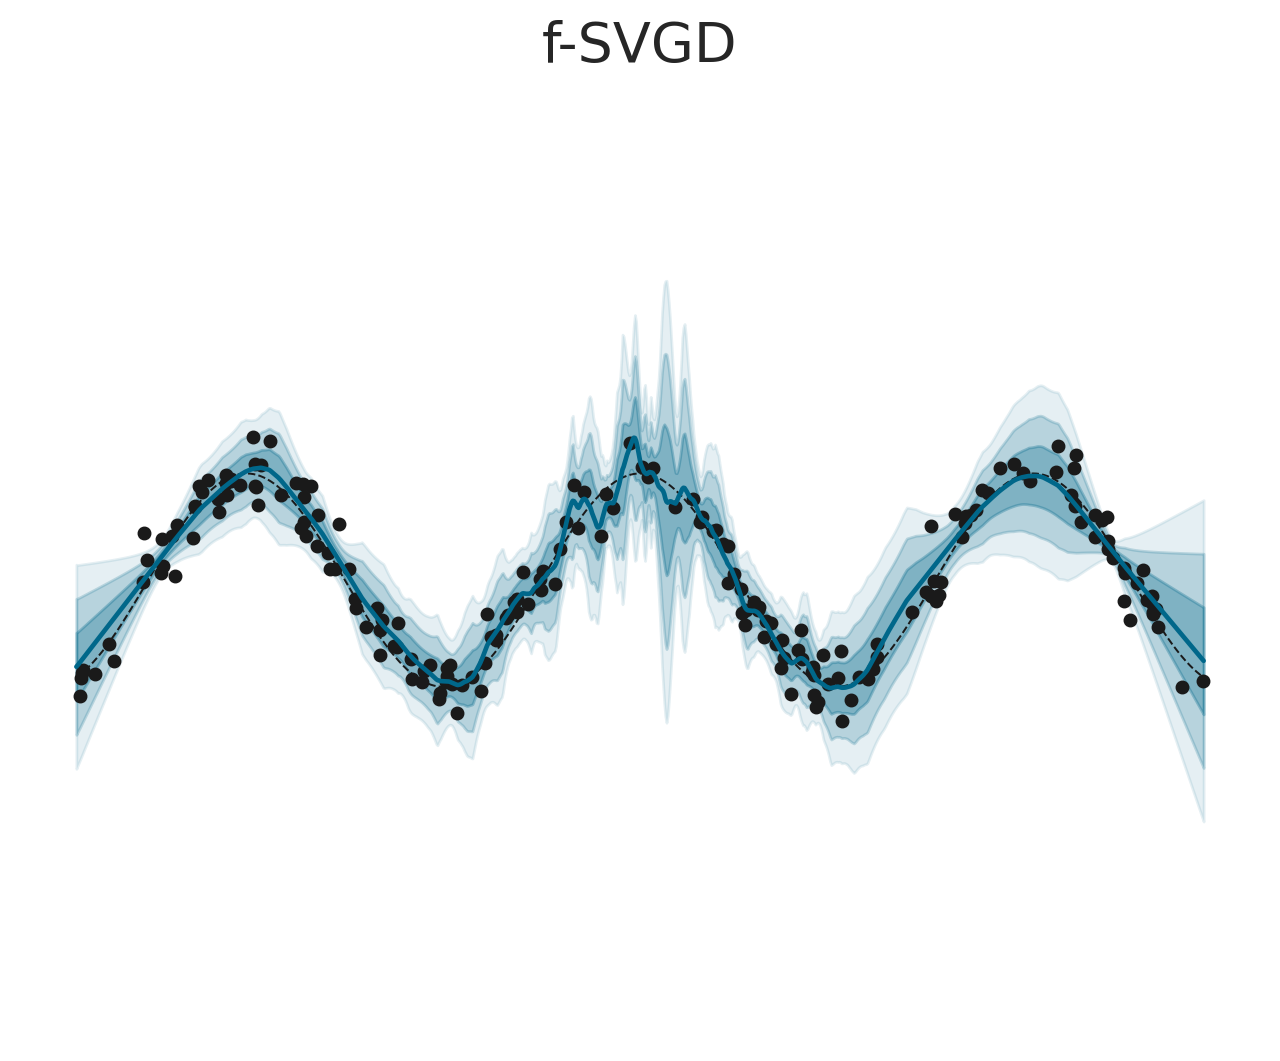

Train iter: 6000  train mse: tensor(0.0330, device='cuda:0') test mse tensor(0.0291, device='cuda:0')


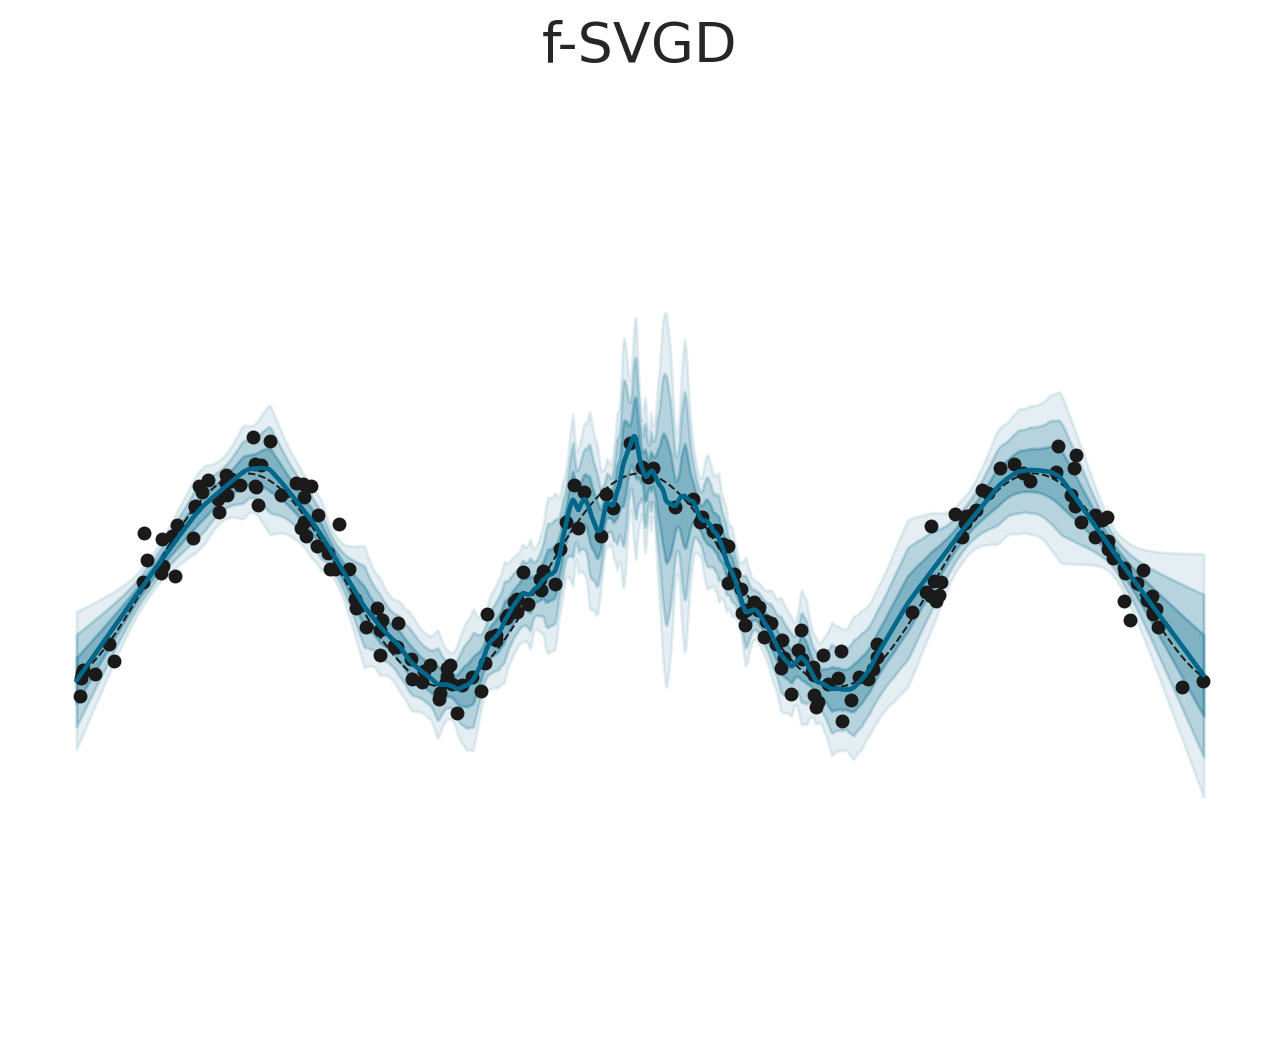

Train iter: 7000  train mse: tensor(0.0244, device='cuda:0') test mse tensor(0.0206, device='cuda:0')


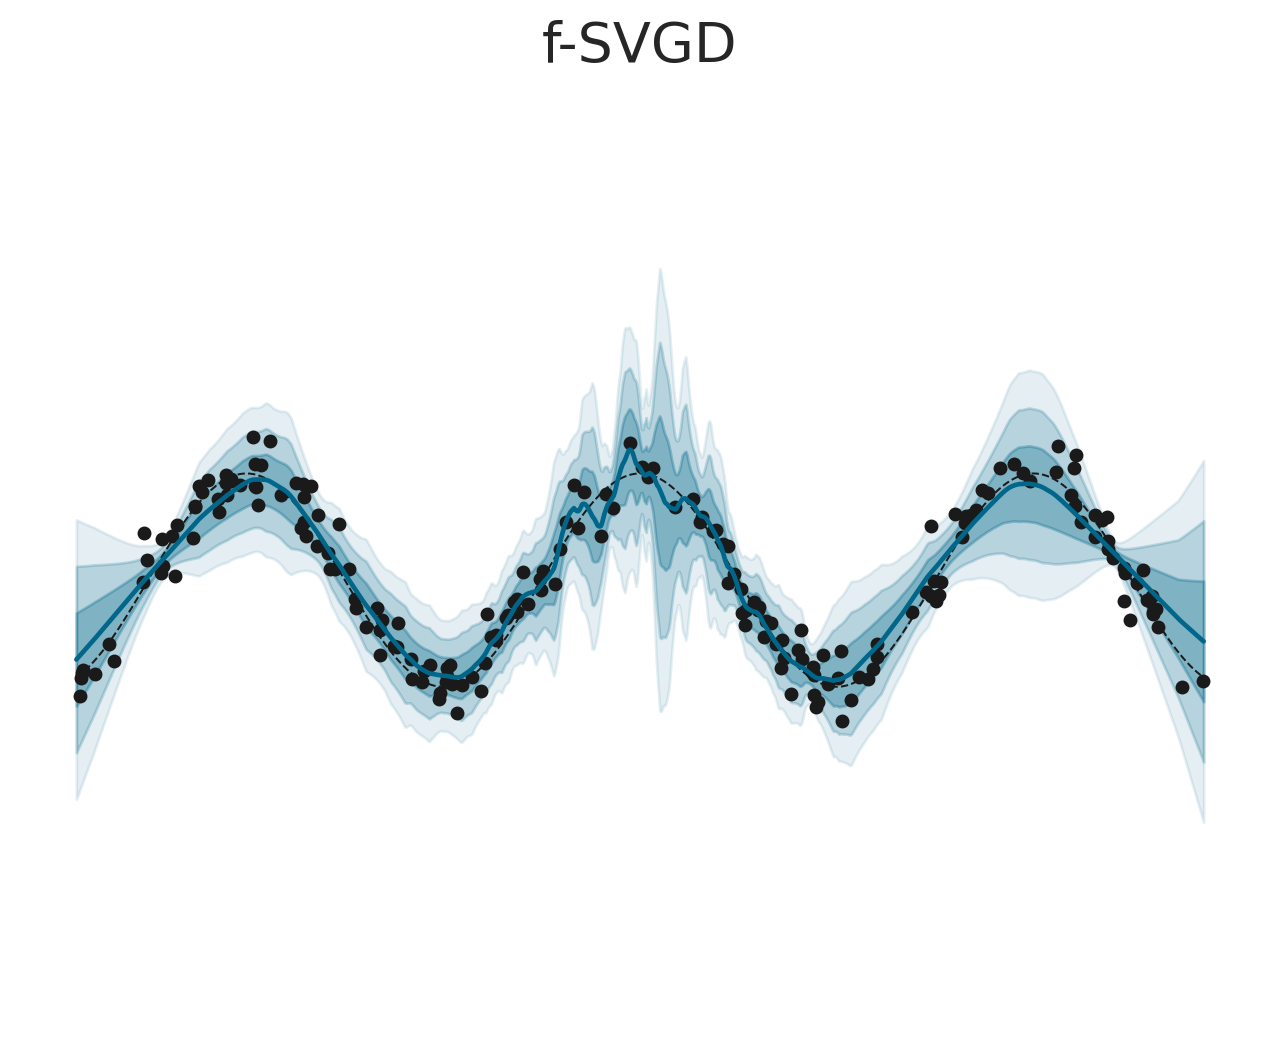

Train iter: 8000  train mse: tensor(0.0380, device='cuda:0') test mse tensor(0.0369, device='cuda:0')


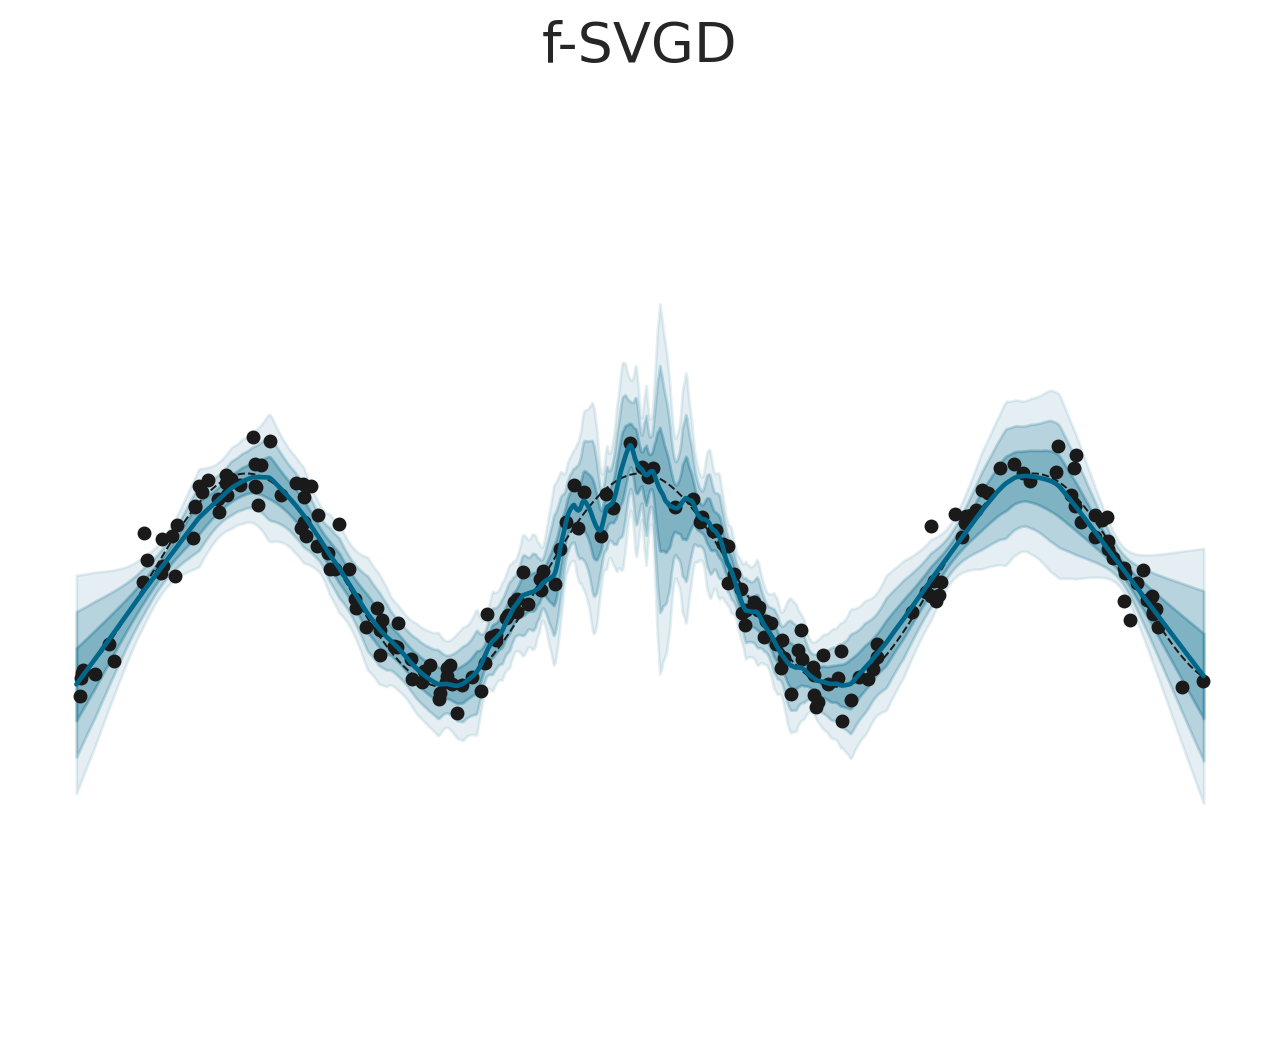

Train iter: 9000  train mse: tensor(0.0267, device='cuda:0') test mse tensor(0.0217, device='cuda:0')


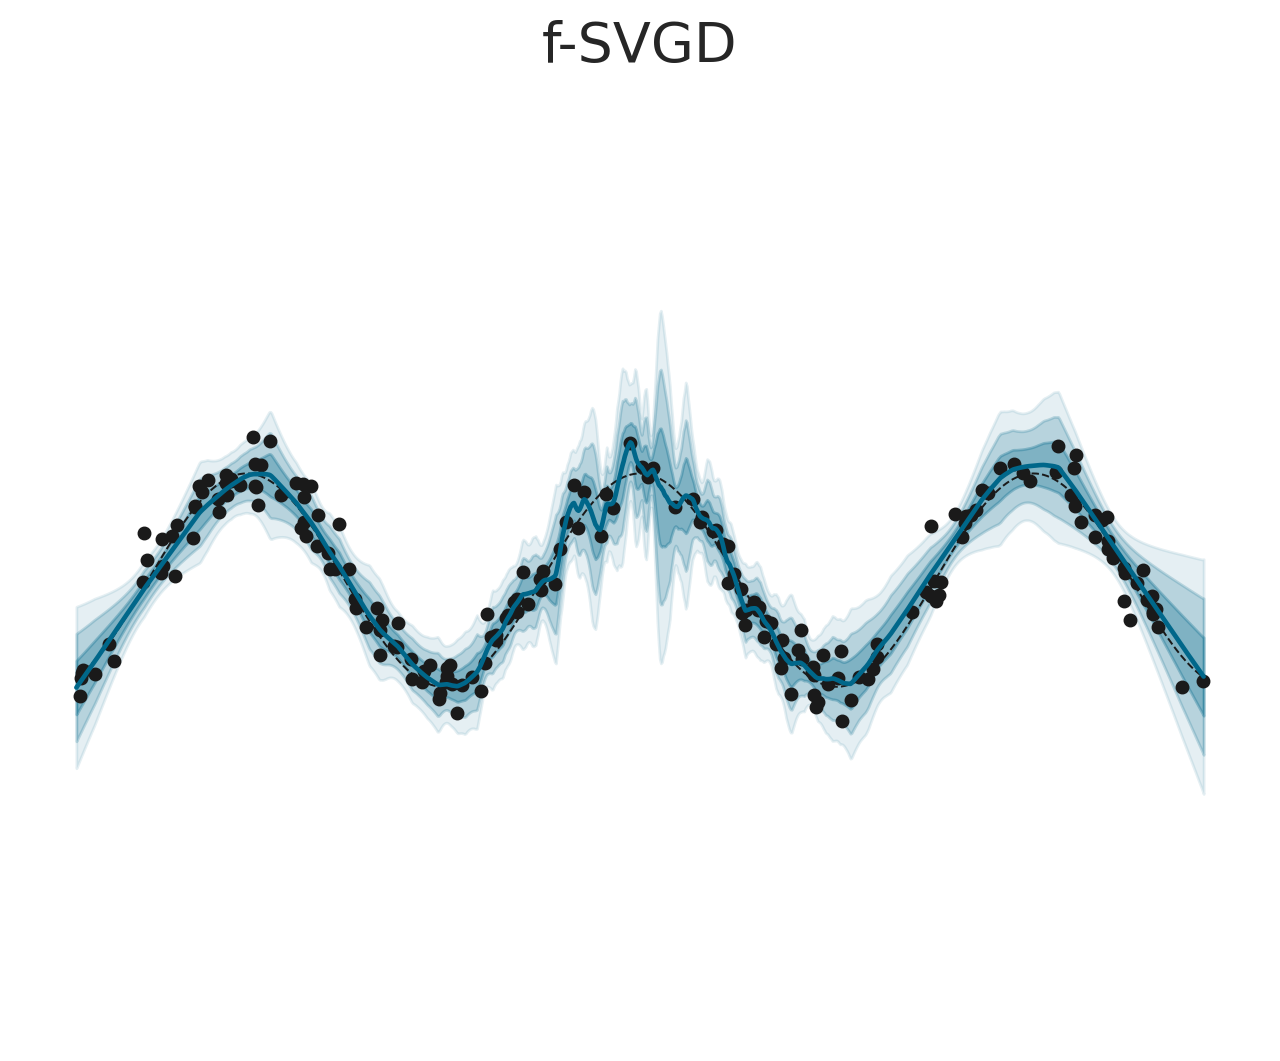

Train iter: 10000  train mse: tensor(0.0248, device='cuda:0') test mse tensor(0.0189, device='cuda:0')


In [8]:
ensemble = Ensemble(device = device, net=mnet, n_particles = config.n_particles)
train(data, ensemble, device, config, writer)